# Processing Doench 2016

Processing resistance screens from [Doench et al. 2016](https://www.nature.com/articles/nbt.3437#MOESM8)

## Data Filtering

1. pdna or etp > mean pdna -3 std
2. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import seaborn as sns
import poola.core as pool
import matplotlib.pyplot as plt
import gpplot

In [2]:
training_data = pd.read_csv('../data/raw/Doench2016_Res_lognorms.csv')

In [3]:
etp_cols = ['none;ETP;A', 'none;ETP;B', 'none;ETP;C', 'none;ETP;D']
filtered_lognorms = pool.filter_pdna(training_data, etp_cols, z_low=-3)
filtered_lognorms = filtered_lognorms.drop(etp_cols + ['Extended Spacer(NNNN[20nt]NGGNNN)', 
                                                       'Strand', 'Transcript', 'Gene Symbol', 
                                                       'Amino Acid Cut position', 'Percent Peptide', 
                                                       'Annotation'], axis=1)
print('pDNA filtered: ' + str(training_data.shape[0] - filtered_lognorms.shape[0]))

pDNA filtered: 101


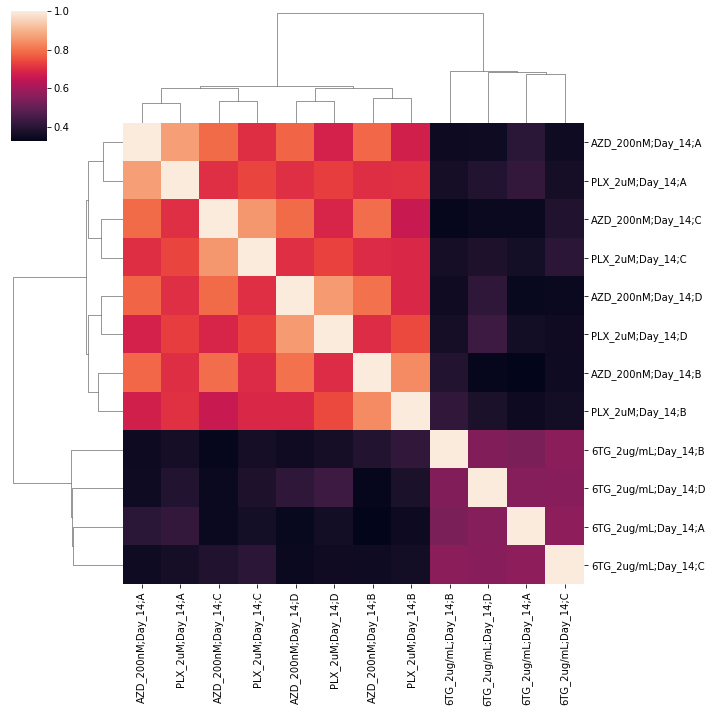

In [4]:
lfcs = pool.calculate_lfcs(filtered_lognorms, 
                           ref_map={'AZD_200nM;Day_14;A': 'DMSO;Day_14;A',
                                    'AZD_200nM;Day_14;B': 'DMSO;Day_14;B', 
                                    'AZD_200nM;Day_14;C': 'DMSO;Day_14;C', 
                                    'AZD_200nM;Day_14;D': 'DMSO;Day_14;D', 
                                    '6TG_2ug/mL;Day_14;A': 'DMSO;Day_14;A',
                                    '6TG_2ug/mL;Day_14;B': 'DMSO;Day_14;B', 
                                    '6TG_2ug/mL;Day_14;C': 'DMSO;Day_14;C', 
                                    '6TG_2ug/mL;Day_14;D': 'DMSO;Day_14;D', 
                                    'PLX_2uM;Day_14;A': 'DMSO;Day_14;A',
                                    'PLX_2uM;Day_14;B': 'DMSO;Day_14;B', 
                                    'PLX_2uM;Day_14;C': 'DMSO;Day_14;C', 
                                    'PLX_2uM;Day_14;D': 'DMSO;Day_14;D'})
lfc_cors = lfcs.corr()
sns.clustermap(lfc_cors)

In [5]:
long_cors = (lfc_cors.reset_index()
             .rename({'index': 'condition rep a'}, axis=1)
             .melt(id_vars='condition rep a', var_name='condition rep b',
                   value_name='r'))
long_cors['condition a'] = long_cors['condition rep a'].str.split('_', expand=True)[0]
long_cors['condition b'] = long_cors['condition rep b'].str.split('_', expand=True)[0]
filtered_cors = long_cors[(long_cors['condition rep a'] != long_cors['condition rep b']) &
                          (long_cors['condition a'] == long_cors['condition b'])]
print('Avg Rep Cor: ' + str(filtered_cors['r'].mean()))


Avg Rep Cor: 0.6908694067421517


In [6]:
sg_list = list(lfcs['Construct Barcode'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [7]:
long_lfcs = pool.average_replicate_lfcs(lfcs, 'Construct Barcode', [0], sep=';')
long_lfcs['condition'] = long_lfcs['condition'].replace({'6TG_2ug/mL': '6TG', 
                                                         'AZD_200nM': 'Selumetinib', 
                                                         'PLX_2uM': 'Vemurafenib'})

In [8]:
lfcs_designs = (long_lfcs.rename({'Construct Barcode': 'sgRNA Sequence'}, axis=1)
                .merge(design_df, how = 'inner', on = 'sgRNA Sequence'))
filtered_lfcs = lfcs_designs[lfcs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
str('Off target filtered: ' + str(lfcs_designs.shape[0] - filtered_lfcs.shape[0]))

'Off target filtered: 132'

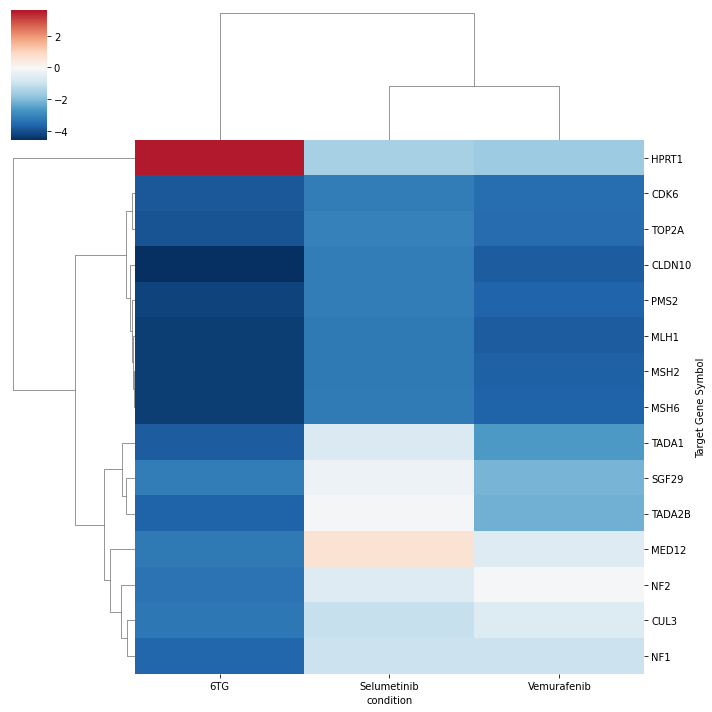

In [9]:
lfc_summaries = (filtered_lfcs.groupby(['Target Gene Symbol', 'condition'])
                 .agg(avg_lfc = ('avg_lfc', 'mean'),
                      count = ('avg_lfc', 'count'),
                      std = ('avg_lfc', 'std'))
                 .reset_index())
sns.clustermap(lfc_summaries.pivot_table(index='Target Gene Symbol', values='avg_lfc', columns='condition'),
               center=0, cmap='RdBu_r')

In [10]:
gene_categories = pd.DataFrame({'condition': ['6TG', 'Selumetinib', 'Vemurafenib', 'fp'], 
                                'Target Gene Symbol': [['HPRT1'],
                                         ['NF1', 'CUL3', 'NF2', 'MED12',
                                          'TADA2B', 'SGF29', 'TADA1'], 
                                         ['NF1', 'CUL3', 'NF2', 'MED12'], 
                                         ['MSH6', 'MSH2', 'MLH1', 'PMS2', 
                                          'CLDN10', 'TOP2A', 'CDK6']]}).explode('Target Gene Symbol')
filtered_lfcs['neg_lfc'] = -filtered_lfcs['avg_lfc']
roc_aucs, _ = pool.get_roc_aucs(lfcs=filtered_lfcs,
                                tp_genes=gene_categories.loc[gene_categories.condition == '6TG', 'Target Gene Symbol'],
                                fp_genes=gene_categories.loc[gene_categories.condition == 'fp', 'Target Gene Symbol'],
                                gene_col='Target Gene Symbol',
                                score_col='neg_lfc', condition_col='condition')
roc_aucs

,condition,ROC-AUC
0,6TG,0.972172
1,Selumetinib,0.916746
2,Vemurafenib,0.914932


In [11]:
roc_aucs, _ = pool.get_roc_aucs(lfcs=filtered_lfcs,
                                tp_genes=gene_categories.loc[gene_categories.condition == 'Selumetinib', 'Target Gene Symbol'],
                                fp_genes=gene_categories.loc[gene_categories.condition == 'fp', 'Target Gene Symbol'],
                                gene_col='Target Gene Symbol',
                                score_col='neg_lfc', condition_col='condition')
roc_aucs

,condition,ROC-AUC
0,6TG,0.743597
1,Selumetinib,0.931838
2,Vemurafenib,0.911763


In [12]:
roc_aucs, _ = pool.get_roc_aucs(lfcs=filtered_lfcs,
                                tp_genes=gene_categories.loc[gene_categories.condition == 'Vemurafenib', 'Target Gene Symbol'],
                                fp_genes=gene_categories.loc[gene_categories.condition == 'fp', 'Target Gene Symbol'],
                                gene_col='Target Gene Symbol',
                                score_col='neg_lfc', condition_col='condition')
roc_aucs

,condition,ROC-AUC
0,6TG,0.746254
1,Selumetinib,0.933223
2,Vemurafenib,0.924831


In [13]:
relevant_sgs_designs = filtered_lfcs.merge(gene_categories, how='inner', 
                                           on=['condition', 'Target Gene Symbol'])
relevant_sgs_designs['gene_rank'] = (relevant_sgs_designs.groupby(['Target Gene Symbol', 'condition'])
                             .avg_lfc
                             .rank(pct=True, ascending=True))
sg_avg_rank = (relevant_sgs_designs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                     'Target Cut %', 'On-Target Efficacy Score'])
               .agg(avg_rank = ('gene_rank', 'mean'))
               .reset_index())

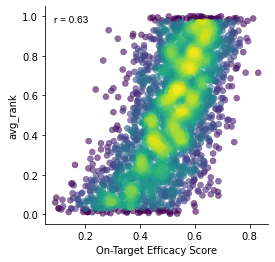

In [14]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sg_avg_rank, y='avg_rank', x='On-Target Efficacy Score')
gpplot.add_correlation(data=sg_avg_rank, y='avg_rank', x='On-Target Efficacy Score')
sns.despine()

In [15]:
training_data = sg_avg_rank.drop('On-Target Efficacy Score', axis=1)
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_rank
0,AAAAAACCTACCGTAAACTC,TTTTAAAAAACCTACCGTAAACTCGGGTCA,NF1,65.5,0.877732
1,AAAAATAGGATTCCCAGCTT,AATAAAAAATAGGATTCCCAGCTTTGGAAG,NF1,56.0,0.487705
2,AAAAATATGTAAACAGCATT,GATGAAAAATATGTAAACAGCATTTGGGAC,CUL3,4.2,0.097403
3,AAAAATTCTAACGTGAGGTG,TTCCAAAAATTCTAACGTGAGGTGTGGCTC,NF1,67.4,0.245219
4,AAAACATGTTCCAGAGCAGT,TTAGAAAACATGTTCCAGAGCAGTTGGTAG,NF1,44.5,0.516393
...,...,...,...,...,...
2531,TTTGCCAAGAGATGAAATTT,TCATTTTGCCAAGAGATGAAATTTAGGTGA,NF1,36.8,0.128415
2532,TTTGGTGTGGCTGACTGAGT,GCACTTTGGTGTGGCTGACTGAGTGGGCCA,CUL3,67.0,0.746753
2533,TTTGTAAGAACCCGCTGTGT,TTCTTTTGTAAGAACCCGCTGTGTTGGTTT,CUL3,83.2,0.581169
2534,TTTGTCATCGTAGGAAGATA,GCCCTTTGTCATCGTAGGAAGATATGGCTG,TADA2B,21.7,0.864583


In [16]:
training_data.to_csv('../data/processed/Doench2016_activity.csv', index=False)